# Reconstructions.ipynb

### Given Bilby parameter estimation results, plot reconstructions using the surrogate model

Maria Okounkova (mokounkova@flatironinstitute.org)

In [132]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from gwpy.timeseries import TimeSeries
from pycbc.detector import Detector
import bilby
from pesummary.io import read
from math import pi
import h5py
from scipy.interpolate import InterpolatedUnivariateSpline
import lal
import lalsimulation as lalsim
import pycbc
from pycbc.filter.matchedfilter import overlap
from scipy.optimize import minimize_scalar
from ipynb.fs.full.Auxiliary import ReadExtrapolatedModes, EvaluateSurrogate, SubtractPeakTime, dt_eval, df_eval, \
                                    PadAndProject, ProjectGivenGeocenterTime, EllinKm, ComputeSNR, ComputeMultiDetectorSNR, \
                                    ComputeMultiDetectorOverlap, ComputeOverlap, TargetSNR
import gwsurrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


### Methods for parameter conversions -- masses, spins, inclination

In [2]:
def EffectiveSpin(params_dict):
    """ Compute effective spin given a parameter dictionary """
    m_1 = params_dict['m_1']
    m_2 = params_dict['m_2']
    a_1 = params_dict['a_1'][2] ## grab z component of spin
    a_2 = params_dict['a_2'][2]
    return (a_1/m_1 + a_2/m_2)/(m_1 + m_2)

def MassParameters(BilbyRes):
    """ Compute individual masses and total mass given bilby result """
    q = 1.0/BilbyRes['mass_ratio']
    chirp = BilbyRes['chirp_mass']
    mass = chirp * (q/(1+q)**2)**(-3/5)
    m_2 = mass / (1 + q)
    m_1 = q*m_2
    return m_1, m_2, mass

def change_spin_convention(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1,
                           m2, f_ref, phi_orb=0.):
    """ Change spin convention for Bilby / lal quantities to surrogate model quantities """
    iota, S1x, S1y, S1z, S2x, S2y, S2z = lalsim.SimInspiralTransformPrecessingNewInitialConditions(
                                             theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2,
                                             m1*lal.MSUN_SI, m2*lal.MSUN_SI, f_ref, phi_orb)
    spin1 = [S1x, S1y, S1z]
    spin2 = [S2x, S2y, S2z]
    return spin1, spin2, iota

def Compute_Spins(bilby_result):
    """ Given a bilby result, compute chi_1 and chi_2, as well as the inclination angle in the form 
        to be passed to a surrogate model """
    
    theta_jn = bilby_result['theta_jn']
    phi_jl = bilby_result['phi_jl']
    tilt1 = bilby_result['tilt_1']
    tilt2 = bilby_result['tilt_2']
    phi12 = bilby_result['phi_12']
    a1 = bilby_result['a_1']
    a2 = bilby_result['a_2']
    m1, m2, mass = MassParameters(bilby_result)
    phi_orb = bilby_result['phase'] ## phase of coalescence at some fiducial time 
    f_ref = 25 ## for now
    spin1, spin2, iota = change_spin_convention(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1,
                           m2, f_ref, phi_orb)
    return spin1, spin2, iota

### Methods to read waveform from frames files and read injected parameters

In [3]:
def GetFramesData(p):
    
    det = 'H1'
    sH = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = np.array(sH.times)
    
    det = 'L1'
    sL = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tL = np.array(sH.times)
    
    return tH, sH, tL, sL

def GetInjectedParameters(p):
    """ Return a dictionary of values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    f.close()
    return params

### Methods for reading Bilby parameter estimation results

In [4]:
def GetBilbyParameters(p):
    """ Obtain max likelihood Bilby parameters given what the Bilby Slack said """

    result = bilby.core.result.read_in_result(p + "/outdir/fast_tutorial_result.json")
    maxL_ind = np.argmax(np.array(result.posterior['log_likelihood']))
    maxL_point = result.posterior.iloc[maxL_ind]
    maxP_ind = np.argmax(np.array(result.posterior['log_likelihood'] + result.posterior['log_prior']))
    maxP_point = result.posterior.iloc[maxP_ind]

    return maxP_point

def GetMultipleBilbyParameters(p, n_points):
    """ Obtain n_points max likelihood Bilby parameters """

    result = bilby.core.result.read_in_result(p + "/outdir/fast_tutorial_result.json")
    values = np.array(result.posterior['log_likelihood'] + result.posterior['log_prior'])
    
    sorted_indices = (values.argsort()[::-1])[0:n_points]
    result_points = [result.posterior.iloc[index] for index in sorted_indices]

    return result_points

def GetBilbyDict(BilbyRes):
    """ Convert a Bilby max likelihood result into a dictionary of parameters 
        that we can pass into the surrogate model """
    
    BilbyDict = {}
    BilbyDict['dt'] = 1.0/2048.
    
    ## Reciprocal of the mass ratio 
    q = 1.0/BilbyRes['mass_ratio']
    BilbyDict['q'] = q
    
    m_1, m_2, mass = MassParameters(BilbyRes)
    BilbyDict['mass'] = mass
    BilbyDict['m_1'] = m_1
    BilbyDict['m_2'] = m_2
    
    BilbyDict['dist_mpc'] = BilbyRes['luminosity_distance'] 
    BilbyDict['f_low'] = 0.0
    BilbyDict['phi'] = BilbyRes['phase'] ## phase of coalescence (at some fiducial time)
    
    ## Spin computations
    chi_1, chi_2, theta = Compute_Spins(BilbyRes)

    BilbyDict['a_1'] = chi_1
    BilbyDict['a_2'] = chi_2
    chi_eff = EffectiveSpin(BilbyDict)
    BilbyDict['chi_eff'] = chi_eff
    
    BilbyDict['theta'] = theta ## Theta from the spin computation conventions
    
    BilbyDict['ra'] = BilbyRes['ra']
    BilbyDict['dec'] = BilbyRes['dec']
    BilbyDict['geocent_time'] = BilbyRes['geocent_time']
    BilbyDict['pol'] = BilbyRes['psi'] ## polarization (angle on the sky of the pericenter wrt to interferometer -- degenerate for circular orbits
    
    return BilbyDict


### Method for optimizing the phase between the injected waveform and the reconstructed surrogate model, or finding the optimal f_ref for the surrogate, which we are allowed to freely specify

In [78]:
def OptimizePhase(p, param_dict):
    """ Given a time and a strain array in each detector that we want to compare against, and a dictionary of parameters, 
        iterate over possible phases for the surrogate in order to produce the phase with the largest
        overlap """
    
    timeH, strainH, timeL, strainL = GetFramesData(p)
    
    def f(x):
        surrogate_dict = param_dict
        surrogate_dict['phi'] = x
        time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(sur, surrogate_dict)
        timeH_sur, strainH_sur, timeL_sur, strainL_sur = ProjectGivenGeocenterTime(time_sur, h_plus_sur, h_cross_sur, surrogate_dict)
        #ov = ComputeMultiDetectorOverlap(timeH, strainH, timeL, strainL, \
        #                        timeH_sur, strainH_sur, timeL_sur, strainL_sur)
        ov = ComputeOverlap(timeH, strainH, timeH_sur, strainH_sur)
    
        ## 1 minus the overlap since we're doing minimization
        print(1.0 - ov),
        return 1.0 - ov
    
    ## iterate from zero to 2 * pi
    res = minimize_scalar(f, bounds=(-pi/2, 2*pi + pi/2), method = 'bounded')
    return(res.x)

def OptimizeFref(p, param_dict):
    """ Given a time and a strain array in each detector that we want to compare against, and a dictionary of parameters, 
        iterate over possible f_reffor the surrogate in order to produce the phase with the largest
        overlap, since we are allowed to specify f_ref per the surrogate documentation """
    
    timeH, strainH, timeL, strainL = GetFramesData(p)
    
    def f(x):
        surrogate_dict = param_dict
        surrogate_dict['f_ref'] = x
        time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(sur, surrogate_dict)
        timeH_sur, strainH_sur, timeL_sur, strainL_sur = ProjectGivenGeocenterTime(time_sur, h_plus_sur, h_cross_sur, surrogate_dict)
        #ov = ComputeMultiDetectorOverlap(timeH, strainH, timeL, strainL, \
        #                        timeH_sur, strainH_sur, timeL_sur, strainL_sur)
        ov = ComputeOverlap(timeH, strainH, timeH_sur, strainH_sur)
    
        ## 1 minus the overlap since we're doing minimization
        #print(1.0 - ov),
        return 1.0 - ov
    
    ## iterate from zero to 2 * pi
    res = minimize_scalar(f, bounds=(35.0, 40.0), method = 'bounded')
    return(res.x)

F_Ref_Opt = {"0p0" : 37.139206751232194, "0p2" : 36.54634655523701, "0p25" : 39.069711438814245, "0p3" : 36.30156691514743, \
             "0p33" : 36.51347727530622, "0p35" : 36.67668072136832, "0p37" : 36.45237815312479}

### Method for doing a full Bilby waveform reconstruction

In [146]:
def BilbyReconstruction(p):
    """ Reconstruct Bilby waveforms from bilby run located in directory p """

    ## Read in bilby parameters
    bilby_result = GetBilbyParameters(p)
    bilby_dict = GetBilbyDict(bilby_result)
    
    ## f_ref optimization
    #f_ref_opt = OptimizeFref(p, bilby_dict)
    #bilby_dict['f_ref'] = f_ref_opt
    bilby_dict['f_ref'] = F_Ref_Opt[p.split('_')[2]]
    #print('Bilby result phi:', bilby_dict['phi'], 'Bilby result pol:', bilby_dict['pol'], 'f_ref:', bilby_dict['f_ref'])
    
    time_bil, h_plus_bil, h_cross_bil, amp_bil = EvaluateSurrogate(sur, bilby_dict) 
    timeH_bil, strainH_bil, timeL_bil, strainL_bil = ProjectGivenGeocenterTime(time_bil, h_plus_bil, h_cross_bil, bilby_dict)

    return timeH_bil, strainH_bil, timeL_bil, strainL_bil, bilby_dict

### Perform and plot reconstructions

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1512: UserWarning: Spin magnitude of BhA=0.8207 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiAmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1515: UserWarning: Spin magnitude of BhB=0.9607 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiBmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1512: UserWarning: Spin magnitude of BhA=0.9191 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiAmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1515: UserWarning: Spin magnitude of BhB=0.9859 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiBmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1512: UserWarning: Spin magnitude of BhA=0.965

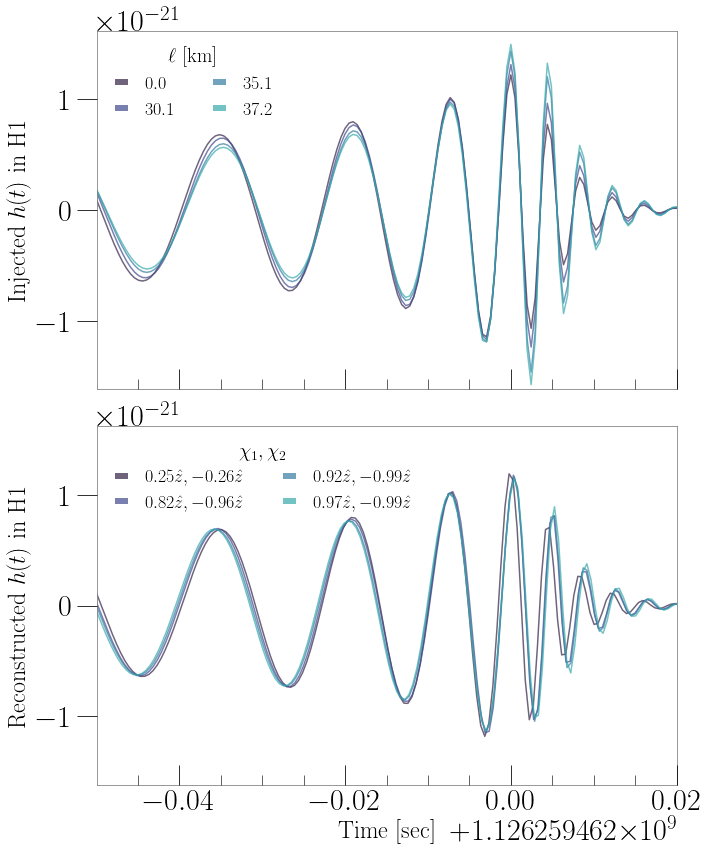

In [135]:
def PlotReconstructions():
    """ Plot Bilby reconstructed waveforms for a variety of Bilby runs"""
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    SNR = '75'
    
    ## Grab the mass from the truth dictionary
    p_gr = base_dir + 'NoTilt_dCS_0p0_' + SNR + '/'
    TruthDict = GetInjectedParameters(p_gr)
    mass = TruthDict['mass']
    
    fig, axes = plt.subplots(2, figsize=(10,12), sharex = True)
    
    ells = ['0p0', '0p3','0p35', '0p37']
    cs = sns.color_palette('mako', n_colors=len(ells) + 1)
    
    for ell, color in zip(ells, cs):

        p = base_dir + 'NoTilt_dCS_' + ell + '_' + SNR + '/'
        ## Injected data
        timeH, strainH, timeL, strainL = GetFramesData(p)
        ## GR attempt at reconstructing data
        timeH_bil, strainH_bil, timeL_bil, strainL_bil, bilby_dict = BilbyReconstruction(p)

        axes[0].plot(timeH, strainH, lw = 1.5, color = color, alpha = 0.7, label = r'$%.1f$' % EllinKm(ell, mass))
        axes[1].plot(timeH_bil, strainH_bil, lw = 1.5, color = color, alpha = 0.7, \
                     label = r'$%.2f \hat{z}, -%.2f \hat{z}$' % (np.abs(bilby_dict['a_1'][2]), np.abs(bilby_dict['a_2'][2])))
    
    axes[0].set_ylabel(r'Injected $h(t)$ in H1')
    axes[1].set_ylabel(r'Reconstructed $h(t)$ in H1')   
    leg0 = axes[0].legend(fontsize=18, loc = 'upper left', frameon=False, ncol = 2, title = r'$\ell$ [km]')
    plt.setp(leg0.get_title(),fontsize=20)
    leg1 = axes[1].legend(fontsize=18, loc = 'upper left', frameon=False, ncol = 2, title = r'$\chi_1, \chi_2$')
    plt.setp(leg1.get_title(),fontsize=20)
    
    
    for ax in axes:
        ax.grid()
        ax.tick_params(axis='x', which='both', bottom=True, top=False) 
        ax.set_ylim(-1.62e-21, 1.62e-21)
        ax.set_xlim(-0.05 + TruthDict['t_gps'], 0.02 + TruthDict['t_gps'])

    plt.xlabel('Time [sec]')
    plt.tight_layout()
    plt.savefig('BilbyReconstructionsTogether.pdf')
    plt.show()

    
PlotReconstructions()

### Plot reconstructions with multiple panels

/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/NoTilt_dCS_0p0_75/
Bilby result phi: 3.4194973534161015 Bilby result pol: 1.2874811818019847 f_ref: 37.139206751232194
Surrogate phase evaluation:  -1.848701026621205 f_low: 0.0 f_ref: 37.139206751232194
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/NoTilt_dCS_0p25_75/
Bilby result phi: 4.169398589237477 Bilby result pol: 5.031265286702064 f_ref: 39.069711438814245
Surrogate phase evaluation:  -2.59860226244258 f_low: 0.0 f_ref: 39.069711438814245


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1515: UserWarning: Spin magnitude of BhB=0.8296 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiBmag, chiMax))


/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/NoTilt_dCS_0p33_75/
Bilby result phi: 3.4628502192633848 Bilby result pol: 1.3214585967465342 f_ref: 36.51347727530622
Surrogate phase evaluation:  -1.8920538924684882 f_low: 0.0 f_ref: 36.51347727530622


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1512: UserWarning: Spin magnitude of BhA=0.8857 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiAmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1515: UserWarning: Spin magnitude of BhB=0.9893 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiBmag, chiMax))


/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/NoTilt_dCS_0p37_75/
Bilby result phi: 3.492489588297574 Bilby result pol: 1.6723396116219151 f_ref: 36.45237815312479
Surrogate phase evaluation:  -1.9216932615026776 f_low: 0.0 f_ref: 36.45237815312479


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1512: UserWarning: Spin magnitude of BhA=0.9654 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiAmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1515: UserWarning: Spin magnitude of BhB=0.9881 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiBmag, chiMax))


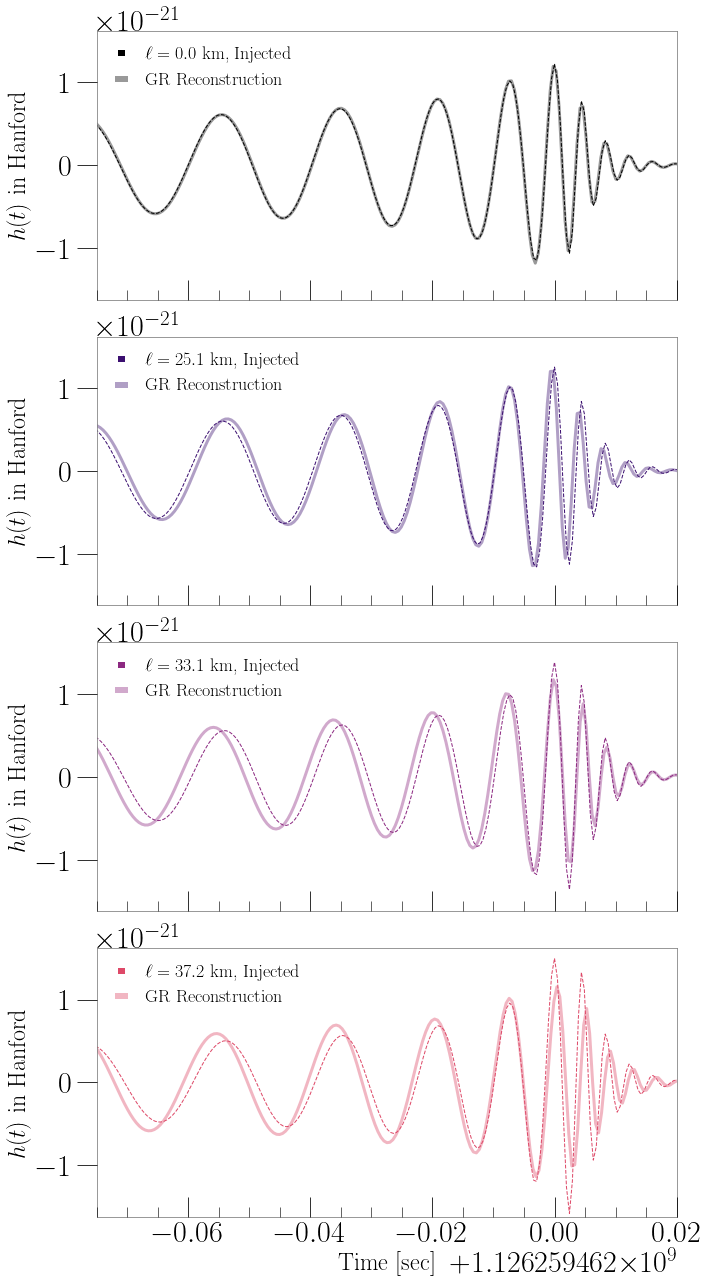

In [136]:
def PlotReconstructionsPanels():
    """ Plot Bilby reconstructed waveforms for a variety of Bilby runs"""
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    SNR = '75'
    
    ## Grab the mass from the truth dictionary
    p_gr = base_dir + 'NoTilt_dCS_0p0_' + SNR + '/'
    TruthDict = GetInjectedParameters(p_gr)
    mass = TruthDict['mass']
    
    ells = ['0p0', '0p25', '0p33', '0p37']
    
    cs = ['black'] + sns.color_palette('magma', n_colors=len(ells))
    
    fig, axes = plt.subplots(len(ells), figsize=(10,18), sharex = True, sharey = True)
    
    for ell, color, ax in zip(ells, cs, axes):

        p = base_dir + 'NoTilt_dCS_' + ell + '_' + SNR + '/'

        timeH, strainH, timeL, strainL = GetFramesData(p)
        timeH_bil, strainH_bil, timeL_bil, strainL_bil, bilby_dict = BilbyReconstruction(p)

        ax.plot(timeH, strainH, lw = 1.0, color = color, ls = '--', label = '$\ell = %.1f$ km, Injected' % EllinKm(ell, mass))
        ax.plot(timeH_bil, strainH_bil, lw = 3.0, color = color, alpha = 0.4, label = 'GR Reconstruction')
        
        ax.legend(fontsize=18, loc = 'upper left', frameon=False)
        ax.set_ylabel(r'$h(t)$ in Hanford')
        ax.tick_params(axis='x', which='both', bottom=True, top=False) 
        ax.set_ylim(-1.62e-21, 1.62e-21)
        ax.grid()
        
    plt.xlim(-0.075 + TruthDict['t_gps'], 0.02 + TruthDict['t_gps'])
    plt.xlabel('Time [sec]')
    plt.tight_layout()
    plt.savefig('BilbyReconstructions.pdf')
    plt.show()

    
PlotReconstructionsPanels()

### Plot multiple waveform reconstructions

In [ ]:
def PlotMultipleReconstructions():

    plt.figure(figsize=(16,8))
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    
    ## Injected parameters
    p = base_dir + 'NoTilt_dCS_0p37_75'
    truth_dict = GetInjectedParameters(p)
    print(truth_dict)
    timeH, strainH, timeL, strainL = GetFramesData(p)
    
    ## Plot multiple reconstructed waveforms
    bilby_results = GetMultipleBilbyParameters(p, 50)

    for bilby_result in bilby_results:
        
        bilby_dict = GetBilbyDict(bilby_result)
        bilby_dict['phi'] = bilby_dict['phi']
        time_bil, h_plus_bil, h_cross_bil, amp_bil = EvaluateSurrogate(sur, bilby_dict) 
        timeH_bil, strainH_bil, timeL_bil, strainL_bil = ProjectGivenGeocenterTime(time_bil, h_plus_bil, h_cross_bil, bilby_dict)

        plt.plot(timeH_bil, strainH_bil, lw = 0.5, color = 'gray', alpha = 0.2)

    ## Plot GR waveform   
    plt.plot(timeH, strainH, lw = 2.0, color = '#1ae863', label = 'Injection', ls = '--')
    
    plt.xlim(-0.15 + truth_dict['t_gps'], 0.033 + truth_dict['t_gps'])
    plt.xlabel('Time [sec]')
    plt.ylabel(r'$h(t)$ in Hanford')
    legend = plt.legend(fontsize=18, loc = 'lower left', frameon=True)
    plt.grid()
    plt.tight_layout()
    plt.savefig('BilbyMultipleReconstructions.pdf')
    plt.show()

#PlotMultipleReconstructions()

### Evaluate GR Surrogate with various spins

In an effort to understand why the Bilby results prefer higher spins for the beyond-GR case, see what happens when spins are increased for the surrogate at fixed mass ratio, chirp mass, tilts, SNR, etc

In [ ]:
def SurrogateVariousSpins():
    """ Plot surrogate waveforms for different values of the spins a_1 and a_2 while keeping the mass ratio constant
        and ensuring that chi_eff ~ 0"""
    
    
    ## Plot for the actual bilby spin values as they change
    ## Plot the actual Bilby reconstructions
    
    desired_snr = 75
    
    plt.figure(figsize=(14, 8))
    
    a_1s = [0.0, 0.25, 0.5, 0.75]
    cs = ['black'] + sns.color_palette('magma', n_colors=len(a_1s))
    
    for a_1, color in zip(a_1s, cs): 
    
        a_2 = a_1 / 1.2212532137858916 ## mass ratio
        
        params_dict = {'dt' : 1/2048, 't_gps' : 1126259462.0, 'peak_time_in_segment' : 8.0, 'segment_length' : 16.0, \
               'dist_mpc' : 400.0, 'mass' : 68.0, 'q' : 1.2212532137858916, \
               'a_1' : [0, 0, a_1], 'a_2' : [0,0, -a_2], \
               'f_low' : 25, 'theta' : pi, 'phi' : 0, \
               'ra' : 1.952318922, 'dec' : -1.26967171703, 'pol' : 0.824043851821, 'geocent_time': 1126259461.9841547, \
                'm_1': 37.38665093292035, 'm_2': 30.61334906707965, 'mass_ratio': 0.8188310079446952, 'chirp_mass': 29.422167356249002}
        
        
        chi_eff = EffectiveSpin(params_dict)
        print("Effective spin: ", chi_eff)
    
        time, h_plus, h_cross, amp = EvaluateSurrogate(sur, params_dict)
        
        ## Now compute the SNR in the detectors and scale accordingly
        current_dist = params_dict['dist_mpc']
        timeH, strainH, timeL, strainL = ProjectGivenGeocenterTime(time, h_plus, h_cross, params_dict)
        strainH, strainL, params_dict = TargetSNR(timeH, strainH, timeL, strainL, params_dict, desired_snr)
        updated_dist = params_dict['dist_mpc']
        #h_plus = h_plus * current_dist / updated_dist
        #h_cross = h_cross * current_dist / updated_dist

        plt.plot(timeH, strainH, label = '$a_1 = %.3f, a_2 = %.3f$' % (a_1, a_2), lw = 1.0, color = color)
        

    plt.xlim(-0.15 +  params_dict['t_gps'], 0.02 +  params_dict['t_gps'])
    plt.xlabel('Time [sec]')
    plt.ylabel(r'$h(t)$ in Hanford')
    legend = plt.legend(fontsize=24, loc = 'lower left', ncol=2, frameon=False)
    plt.grid()
    plt.show()
    
#SurrogateVariousSpins()